In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd
import itertools
import timeit
from copy import deepcopy

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import make_scorer
%matplotlib inline

In [3]:
warnings.filterwarnings('ignore')

In [4]:
np.random.seed(1)

In [5]:
%%time

UsageError: %%time is a cell magic, but the cell body is empty. Did you mean the line magic %time (single %)?


# load  white wine

In [6]:
wine = pd.read_csv("winequality-white.csv", delimiter=";")

In [7]:
wine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


# load abalone - the header was preppended manually in data file

In [8]:
abalone = pd.read_csv("abalone.data", delimiter=",")

In [9]:
abalone

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


#### abalone max-mins

In [10]:
print("min, max pairs for each column (gender is skipped)")
for i in range(1,9):
    print(str(abalone.to_numpy()[:,i].min()) + 
          ", " + str(abalone.to_numpy()[:,i].max()) +
         "\t" + abalone.columns[i])

min, max pairs for each column (gender is skipped)
0.075, 0.815	Length
0.055, 0.65	Diameter
0.0, 1.13	Height
0.002, 2.8255	Whole weight
0.001, 1.488	Shucked weight
0.0005, 0.76	Viscera weight
0.0015, 1.005	Shell weight
1, 29	Rings


#### wine max-mins

In [11]:
print("min, max pairs for each column")
for i in range(0, 12):
    print(str(wine.to_numpy()[:,i].min()) + 
          ", " + str(wine.to_numpy()[:,i].max()) +
         "\t" + wine.columns[i])

min, max pairs for each column
3.8, 14.2	fixed acidity
0.08, 1.1	volatile acidity
0.0, 1.66	citric acid
0.6, 65.8	residual sugar
0.009, 0.346	chlorides
2.0, 289.0	free sulfur dioxide
9.0, 440.0	total sulfur dioxide
0.98711, 1.03898	density
2.72, 3.82	pH
0.22, 1.08	sulphates
8.0, 14.2	alcohol
3.0, 9.0	quality


### wine class distribution

(array([  20.,  163., 1457., 2198.,  880.,  175.,    5.]),
 array([ 3,  4,  5,  6,  7,  8,  9, 10]),
 <BarContainer object of 7 artists>)

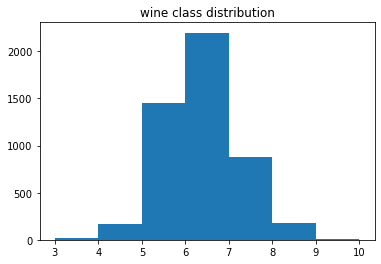

In [12]:
df_w = deepcopy(wine)
plt.title("wine class distribution")
plt.hist(df_w['quality'], bins=range(3,11))

# drop wine classes with quality 9 and 3, since they have very low sample sizes of 5 and 20, respectively

In [13]:
df_w = df_w[df_w['quality'] != 9][df_w['quality'] != 3]

# convert to one-hot sex abalone

In [14]:
df_a = deepcopy(abalone)
df_a.loc[df_a['Sex'] == 'M', 'M'] = 1
df_a.loc[df_a['Sex'] == 'M', 'F'] = 0
df_a.loc[df_a['Sex'] == 'M', 'I'] = 0

df_a.loc[df_a['Sex'] == 'F', 'F'] = 1
df_a.loc[df_a['Sex'] == 'F', 'M'] = 0
df_a.loc[df_a['Sex'] == 'F', 'I'] = 0

df_a.loc[df_a['Sex'] == 'I', 'I'] = 1
df_a.loc[df_a['Sex'] == 'I', 'M'] = 0
df_a.loc[df_a['Sex'] == 'I', 'F'] = 0
df_a=df_a.drop(['Sex'],axis=1)

#### abalone large number of classes (ring count), several outliers. Drop classes with < 14 entries

###### classes with ring count 1 and 2 only have 1 class member each. 
###### classes with ring count greater than 21 have less than 10 class member each

(array([  0.,   1.,   1.,  15.,  57., 115., 259., 391., 568., 689., 634.,
        487., 267., 203., 126., 103.,  67.,  58.,  42.,  32.,  26.,  14.,
          6.,   9.,   2.,   1.,   1.,   2.,   0.,   1.,   0.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 <BarContainer object of 31 artists>)

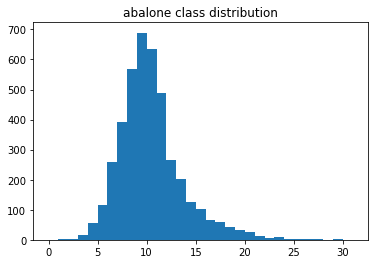

In [15]:
plt.title("abalone class distribution")
plt.hist(df_a['Rings'], bins=range(0,32))

In [16]:
df_a = df_a[df_a['Rings'] < 22][df_a['Rings'] > 2]
df_a

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,M,F,I
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15,1.0,0.0,0.0
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7,1.0,0.0,0.0
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9,0.0,1.0,0.0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10,1.0,0.0,0.0
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
4172,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11,0.0,1.0,0.0
4173,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10,1.0,0.0,0.0
4174,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9,1.0,0.0,0.0
4175,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10,0.0,1.0,0.0


In [17]:
save = df_a['Rings']

In [18]:
save

0       15
1        7
2        9
3       10
4        7
        ..
4172    11
4173    10
4174     9
4175    10
4176    12
Name: Rings, Length: 4153, dtype: int64

# standardardize

#### abalone

In [19]:
df_a = (df_a - df_a.min())/(df_a.max() - df_a.min())

In [20]:
df_a

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,M,F,I
0,0.489362,0.491071,0.084071,0.179592,0.149445,0.132324,0.146707,0.666667,1.0,0.0,0.0
1,0.340426,0.312500,0.079646,0.077196,0.065298,0.063199,0.066866,0.222222,1.0,0.0,0.0
2,0.595745,0.589286,0.119469,0.237445,0.170986,0.185648,0.206587,0.333333,0.0,1.0,0.0
3,0.468085,0.491071,0.110619,0.180302,0.143386,0.149440,0.151697,0.388889,1.0,0.0,0.0
4,0.312057,0.294643,0.070796,0.069920,0.058566,0.051350,0.051896,0.222222,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
4172,0.645390,0.642857,0.146018,0.311979,0.247391,0.314022,0.245509,0.444444,0.0,1.0,0.0
4173,0.680851,0.625000,0.119469,0.340018,0.293840,0.281764,0.256986,0.388889,1.0,0.0,0.0
4174,0.695035,0.687500,0.181416,0.414552,0.352070,0.377880,0.304391,0.333333,1.0,0.0,0.0
4175,0.730496,0.705357,0.132743,0.385626,0.355772,0.342989,0.292415,0.388889,0.0,1.0,0.0


In [21]:
df_a['Rings'] = save

In [22]:
df_a

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,M,F,I
0,0.489362,0.491071,0.084071,0.179592,0.149445,0.132324,0.146707,15,1.0,0.0,0.0
1,0.340426,0.312500,0.079646,0.077196,0.065298,0.063199,0.066866,7,1.0,0.0,0.0
2,0.595745,0.589286,0.119469,0.237445,0.170986,0.185648,0.206587,9,0.0,1.0,0.0
3,0.468085,0.491071,0.110619,0.180302,0.143386,0.149440,0.151697,10,1.0,0.0,0.0
4,0.312057,0.294643,0.070796,0.069920,0.058566,0.051350,0.051896,7,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
4172,0.645390,0.642857,0.146018,0.311979,0.247391,0.314022,0.245509,11,0.0,1.0,0.0
4173,0.680851,0.625000,0.119469,0.340018,0.293840,0.281764,0.256986,10,1.0,0.0,0.0
4174,0.695035,0.687500,0.181416,0.414552,0.352070,0.377880,0.304391,9,1.0,0.0,0.0
4175,0.730496,0.705357,0.132743,0.385626,0.355772,0.342989,0.292415,10,0.0,1.0,0.0


In [23]:
print("min, max pairs for each column")
for i in range(0,11):
    print(str(df_a.to_numpy()[:,i].min()) + 
          ", " + str(df_a.to_numpy()[:,i].max()) +
         "\t" + df_a.columns[i])

min, max pairs for each column
0.0, 1.0	Length
0.0, 1.0	Diameter
0.0, 1.0	Height
0.0, 1.0	Whole weight
0.0, 1.0	Shucked weight
0.0, 1.0	Viscera weight
0.0, 1.0	Shell weight
3.0, 21.0	Rings
0.0, 1.0	M
0.0, 1.0	F
0.0, 1.0	I


In [24]:
print("min, max pairs for each column")
for i in range(1,9):
    print(str(abalone.to_numpy()[:,i].min()) + 
          ", " + str(abalone.to_numpy()[:,i].max()) +
         "\t" + abalone.columns[i])

min, max pairs for each column
0.075, 0.815	Length
0.055, 0.65	Diameter
0.0, 1.13	Height
0.002, 2.8255	Whole weight
0.001, 1.488	Shucked weight
0.0005, 0.76	Viscera weight
0.0015, 1.005	Shell weight
1, 29	Rings


##### Wine

In [25]:
save = df_w['quality']

In [26]:
df_w = (df_w - df_w.min())/(df_w.max() - df_w.min())

In [27]:
df_w['quality'] = save

In [28]:
df_w

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0.307692,0.186275,0.216867,0.308282,0.106825,0.315018,0.480597,0.267785,0.254545,0.267442,0.129032,6
1,0.240385,0.215686,0.204819,0.015337,0.118694,0.087912,0.367164,0.132832,0.527273,0.313953,0.241935,6
2,0.413462,0.196078,0.240964,0.096626,0.121662,0.205128,0.262687,0.154039,0.490909,0.255814,0.338710,6
3,0.326923,0.147059,0.192771,0.121166,0.145401,0.329670,0.528358,0.163678,0.427273,0.209302,0.306452,6
4,0.326923,0.147059,0.192771,0.121166,0.145401,0.329670,0.528358,0.163678,0.427273,0.209302,0.306452,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,0.230769,0.127451,0.174699,0.015337,0.089021,0.161172,0.247761,0.077694,0.500000,0.325581,0.516129,6
4894,0.269231,0.235294,0.216867,0.113497,0.112760,0.402930,0.474627,0.150183,0.390909,0.279070,0.258065,5
4895,0.259615,0.156863,0.114458,0.009202,0.094955,0.205128,0.304478,0.104685,0.245455,0.279070,0.225806,6
4896,0.163462,0.205882,0.180723,0.007669,0.038576,0.131868,0.301493,0.030461,0.563636,0.186047,0.774194,7


# split into train and test - 75% train, 25% test - train_test_split defaults to 75 - 25

##### abalone

In [29]:
Y_a = deepcopy(df_a)["Rings"].to_numpy()
Y_a

array([15,  7,  9, ...,  9, 10, 12])

In [30]:
X_a = deepcopy(df_a).drop("Rings", axis=1).to_numpy()
X_a

array([[0.4893617 , 0.49107143, 0.0840708 , ..., 1.        , 0.        ,
        0.        ],
       [0.34042553, 0.3125    , 0.07964602, ..., 1.        , 0.        ,
        0.        ],
       [0.59574468, 0.58928571, 0.11946903, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.69503546, 0.6875    , 0.18141593, ..., 1.        , 0.        ,
        0.        ],
       [0.73049645, 0.70535714, 0.13274336, ..., 0.        , 1.        ,
        0.        ],
       [0.85106383, 0.83035714, 0.17256637, ..., 1.        , 0.        ,
        0.        ]])

In [31]:
x_train_a, x_test_a, y_train_a, y_test_a = train_test_split(X_a, Y_a, stratify=Y_a,
                                                         random_state=1)

#### wine

In [32]:
Y_w = deepcopy(df_w)["quality"].to_numpy()
Y_w

array([6, 6, 6, ..., 6, 7, 6])

In [33]:
X_w = deepcopy(df_w).drop("quality", axis=1).to_numpy()
X_w

array([[0.30769231, 0.18627451, 0.21686747, ..., 0.25454545, 0.26744186,
        0.12903226],
       [0.24038462, 0.21568627, 0.20481928, ..., 0.52727273, 0.31395349,
        0.24193548],
       [0.41346154, 0.19607843, 0.24096386, ..., 0.49090909, 0.25581395,
        0.33870968],
       ...,
       [0.25961538, 0.15686275, 0.11445783, ..., 0.24545455, 0.27906977,
        0.22580645],
       [0.16346154, 0.20588235, 0.18072289, ..., 0.56363636, 0.18604651,
        0.77419355],
       [0.21153846, 0.12745098, 0.22891566, ..., 0.49090909, 0.11627907,
        0.61290323]])

In [34]:
x_train_w, x_test_w, y_train_w, y_test_w = train_test_split(X_w, Y_w, stratify=Y_w,
                                                         random_state=1)

# Helper plotting function

In [35]:
def helperPlot(xData, yData, curveLabels, xlabel, ylabel, title): 
    fig = plt.figure()
    ax = plt.axes()
    plt.title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    N = len(curveLabels)
    for i in range(N):
        if type(xData[i]) != type([]):
            plt.plot(xData, yData[i], 'o-', label=curveLabels[i])
        else:
            plt.plot(xData[i], yData[i], 'o-', label=curveLabels[i])
        
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

# Hyperparameter graphing

In [36]:
def hyperparameter_vs_score_routine(xtrain, ytrain, xtest, ytest, classifiers, hyperparams, xlabel, title):
    np.random.seed(1)
    f1train =[]
    f1test = []
    for classifier in classifiers:
        # fit classifier to train set
        classifier.fit(xtrain, ytrain)
        # get results predicting on train and test
        ytrain_pred = classifier.predict(xtrain)
        ytest_pred = classifier.predict(xtest)
        # get f1 score for predicting, append them
        f1train.append(f1_score(ytrain, ytrain_pred, average='micro'))
        f1test.append(f1_score(ytest, ytest_pred, average='micro'))
    
    helperPlot(hyperparams, [f1train, f1test], ["Training Set", "Testing Set"], xlabel, "F1 Score", title)

### NN

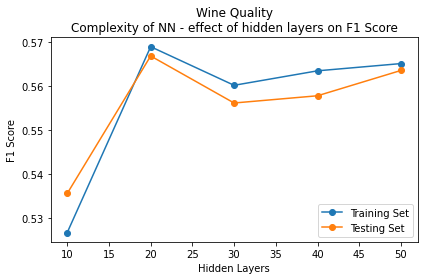

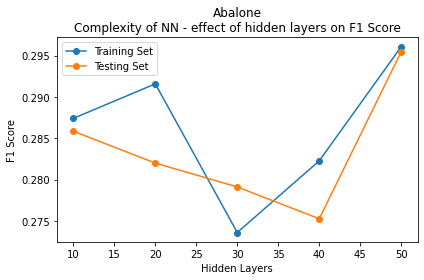

In [37]:
hidden_layers = np.arange(10, 60, 10)
NN_classifers = []
for i in hidden_layers:
    NN_classifers.append(MLPClassifier(hidden_layer_sizes=(i,), solver='adam', activation='relu', 
                                learning_rate_init=0.05, random_state=100))

hyperparameter_vs_score_routine(x_train_w, y_train_w, x_test_w, y_test_w, 
                                NN_classifers, hidden_layers, "Hidden Layers", 
                                "Wine Quality\nComplexity of NN - effect of hidden layers on F1 Score")

hyperparameter_vs_score_routine(x_train_a, y_train_a, x_test_a, y_test_a, 
                                NN_classifers, hidden_layers, "Hidden Layers", 
                                "Abalone\nComplexity of NN - effect of hidden layers on F1 Score")

### SVM

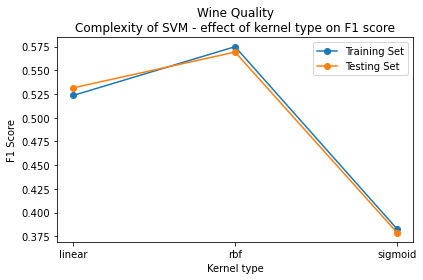

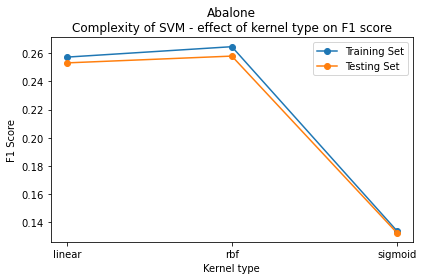

In [38]:
kernel_types = ['linear', 'rbf', 'sigmoid']
SVM_classifiers = []
for i in kernel_types:
    SVM_classifiers.append(SVC(kernel=i,random_state=100))

hyperparameter_vs_score_routine(x_train_w, y_train_w, x_test_w, y_test_w, 
                                SVM_classifiers, kernel_types, "Kernel type", 
                                "Wine Quality\nComplexity of SVM - effect of kernel type on F1 score")

hyperparameter_vs_score_routine(x_train_a, y_train_a, x_test_a, y_test_a, 
                                SVM_classifiers, kernel_types, "Kernel type", 
                                "Abalone\nComplexity of SVM - effect of kernel type on F1 score")

### knn

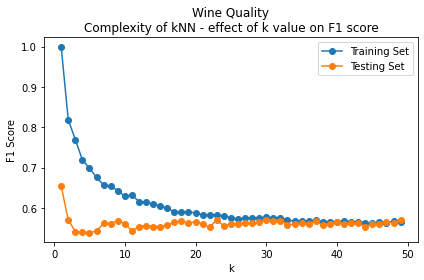

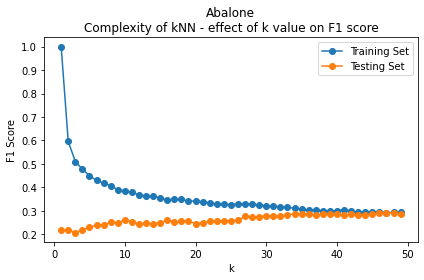

In [39]:
k_values = np.arange(1,50,1).astype(int)
knn_classifiers = []
for i in k_values:
    knn_classifiers.append(KNeighborsClassifier(n_neighbors=i,n_jobs=-1))

hyperparameter_vs_score_routine(x_train_w, y_train_w, x_test_w, y_test_w, 
                                knn_classifiers, k_values, "k", 
                                "Wine Quality\nComplexity of kNN - effect of k value on F1 score")

hyperparameter_vs_score_routine(x_train_a, y_train_a, x_test_a, y_test_a, 
                                knn_classifiers, k_values, "k", 
                                "Abalone\nComplexity of kNN - effect of k value on F1 score")

### trees

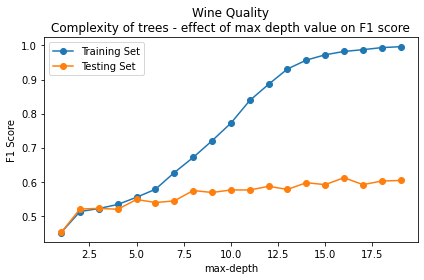

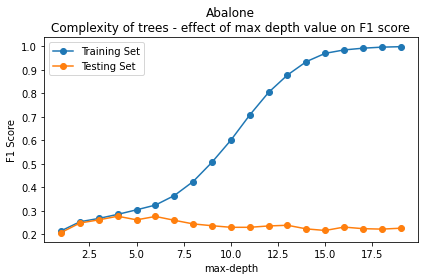

In [40]:
maxdepths = np.arange(1, 20)
tree_classifiers = []
for i in maxdepths:
     tree_classifiers.append(DecisionTreeClassifier(max_depth=i, random_state=100, 
                                                    min_samples_leaf=1, criterion='entropy'))

hyperparameter_vs_score_routine(x_train_w, y_train_w, x_test_w, y_test_w, 
                                tree_classifiers, maxdepths, "max-depth", 
                                "Wine Quality\nComplexity of trees - effect of max depth value on F1 score")

hyperparameter_vs_score_routine(x_train_a, y_train_a, x_test_a, y_test_a, 
                                tree_classifiers, maxdepths, "max-depth", 
                                "Abalone\nComplexity of trees - effect of max depth value on F1 score")

### boosting

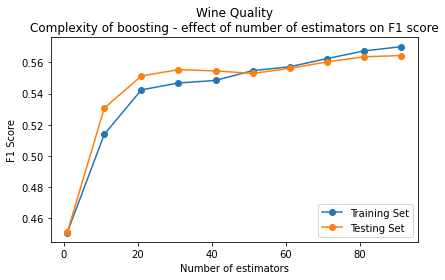

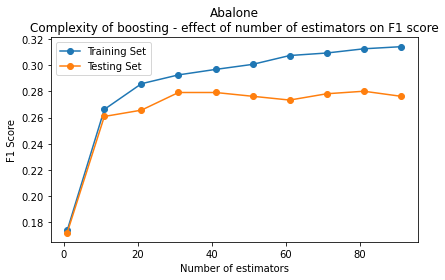

CPU times: user 38.9 s, sys: 144 ms, total: 39.1 s
Wall time: 39.1 s


In [41]:
%%time
num_estimators = np.arange(1,100,10).astype('int')
boosting_classifiers = []

start_leaf = round(0.005*len(x_train_w))
end_leaf = round(0.05*len(x_train_w)) #leaf nodes of size [0.5%, 5% will be tested]
minsamleaf = np.linspace(start_leaf,end_leaf,3).round().astype('int')


for i in num_estimators:
    boosting_classifiers.append(GradientBoostingClassifier(n_estimators=i, max_depth=int(3/2), 
                                             min_samples_leaf=int(50/2), random_state=100,))
                                
hyperparameter_vs_score_routine(x_train_w, y_train_w, x_test_w, y_test_w, 
                                boosting_classifiers, num_estimators, "Number of estimators", 
                                "Wine Quality\nComplexity of boosting - effect of number of estimators on F1 score")

hyperparameter_vs_score_routine(x_train_a, y_train_a, x_test_a, y_test_a, 
                                boosting_classifiers, num_estimators, "Number of estimators", 
                                "Abalone\nComplexity of boosting - effect of number of estimators on F1 score")

## Learning and Modeling Curves

In [42]:
def learning_curve_model_time(classifier, xtrain, ytrain, cv, titlePrepend):
    np.random.seed(1)
    N = len(ytrain)
    train_f1_mean = []
    validation_f1_mean = []
    train_time_mean = []
    pred_time_mean = []
    train_sizes=(np.arange(.1, 1.01, 0.1)*N).astype('int')  
    scoring = {'f1_score' : make_scorer(f1_score, average='micro')}

    for i in train_sizes:
        idx = np.random.randint(N, size=i)
        xsample = xtrain[idx,:]
        ysample = ytrain[idx]
        scores = cross_validate(classifier, xsample, ysample, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=True)
        
        train_f1_mean.append(np.mean(scores['train_f1_score']))
        validation_f1_mean.append(np.mean(scores['test_f1_score']))
        train_time_mean.append(np.mean(scores['fit_time']))
        pred_time_mean.append(np.mean(scores['score_time']))
    
    #Plot learning curve
    helperPlot(train_sizes, [train_f1_mean, validation_f1_mean], ["train", "validation"], "Training Samples",
                "F1 Score", titlePrepend + "\nLearning Curve")
    # plot timing curve
    helperPlot(train_sizes, [train_time_mean, pred_time_mean], ["Training Time", "Prediction Time"], "Training Samples",
               "Time (seconds)", titlePrepend + "\nModeling Time")
    
    return train_f1_mean, validation_f1_mean, train_time_mean, pred_time_mean

In [43]:
def gridSearch(xtrain, ytrain, param_grid, classifier, cv=5):
    np.random.seed(1)
    model = sk.model_selection.GridSearchCV(estimator=classifier, param_grid=param_grid, cv=cv)
    model.fit(xtrain, ytrain)
    return (model.best_params_)

## Test set evaluation

In [44]:
def show_CM(conf_matrix, classes):
    
    plt.subplots(figsize=(10, 10))
    plt.imshow(conf_matrix)
    plt.title("Confusion Matrix")
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    thresh = conf_matrix.max() / 2.
    for i, j in itertools.product(range(len(classes)), range(len(classes))):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="black")
        
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

def evaluate(model, xtrain, ytrain, xtest, ytest):
    np.random.seed(1)
    start = timeit.default_timer()
    model.fit(xtrain, ytrain)
    end = timeit.default_timer()
    training_time = end - start
    start = timeit.default_timer()    
    y_predicted = model.predict(xtest)
    end = timeit.default_timer()
    prediction_time = end - start
    
    result_f1_score = f1_score(ytest, y_predicted, average='macro')
    accuracy = accuracy_score(ytest,y_predicted)
    precision = precision_score(ytest,y_predicted, average='macro')
    recall = recall_score(ytest,y_predicted, average='macro')
    result_confusion_matrix = confusion_matrix(ytest,y_predicted)

    print("Train time: " + str(training_time))
    print("Prediction time: " + str(prediction_time))
    print("F1 Score: " + str(result_f1_score))
    print("Accuracy: " + str(accuracy))
    print("Precision: " + str(precision))
    print("Recall: " + str(recall))
    
    classes = set(list(set(ytrain)) + list(set(ytest)))
    
    show_CM(result_confusion_matrix, list(classes))


#### NN

In [45]:
# best params
param_grid_NN = {'hidden_layer_sizes': np.arange(10, 60, 10), 
              'learning_rate_init': [.01, .03, .05, .07, .1]}

In [46]:
%%time
classifer_NN = MLPClassifier(solver='adam',activation='relu',random_state=100)
best_params_NN_w = gridSearch(x_train_w, y_train_w, param_grid_NN, classifer_NN)
best_params_NN_w

{'hidden_layer_sizes': 30, 'learning_rate_init': 0.05}

In [47]:
%%time
classifer_NN = MLPClassifier(solver='adam',activation='relu',random_state=100)
best_params_NN_a = gridSearch(x_train_a, y_train_a, param_grid_NN, classifer_NN)
best_params_NN_a

{'hidden_layer_sizes': 10, 'learning_rate_init': 0.01}

/home/drautuna/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/drautuna/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/drautuna/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


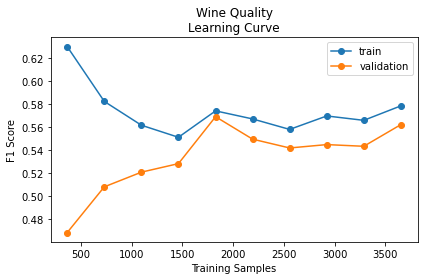

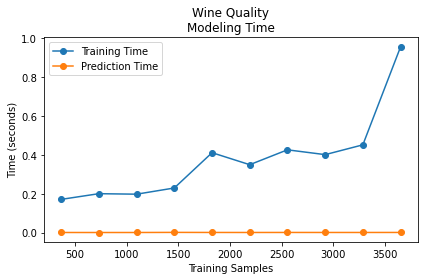

In [48]:
model_NN_w = MLPClassifier(solver='adam',activation='relu',random_state=100, 
                           hidden_layer_sizes=30, learning_rate_init=0.05)
curve_NN_w = learning_curve_model_time(model_NN_w, x_train_w, y_train_w, 5, "Wine Quality")

Train time: 0.49985790000937413
Prediction time: 0.0005980999994790182
F1 Score: 0.334571719733963
Accuracy: 0.5561936013125512
Precision: 0.3801856124038501
Recall: 0.3358699836748617


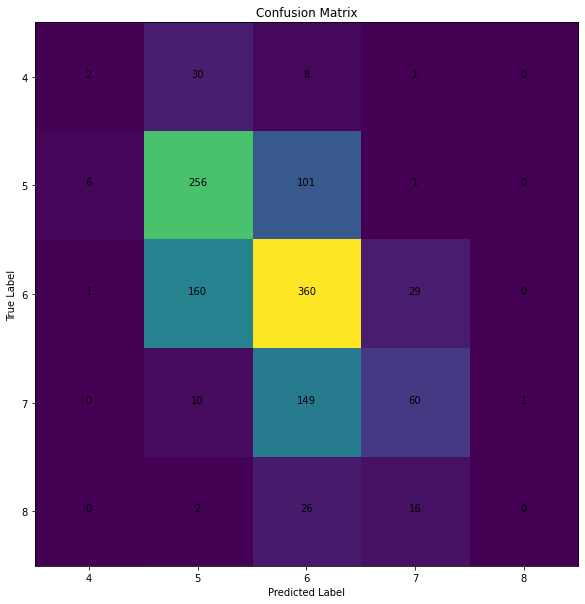

In [49]:
evaluate(model_NN_w, x_train_w, y_train_w, x_test_w, y_test_w)

/home/drautuna/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/drautuna/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/drautuna/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/drautuna/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/drautuna/anaconda3/lib/pyt

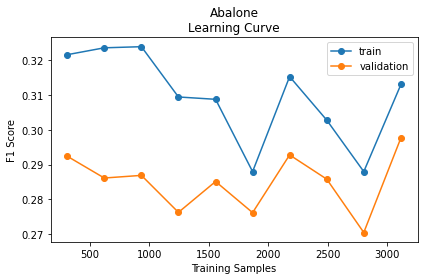

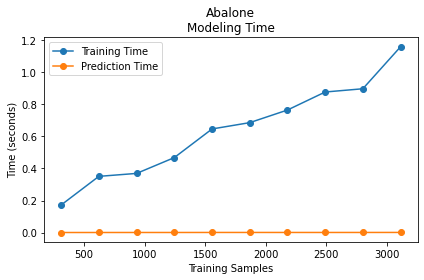

In [50]:
model_NN_a = MLPClassifier(solver='adam',activation='relu',random_state=100, 
                           hidden_layer_sizes=10, learning_rate_init=0.01)
curve_NN_a =learning_curve_model_time(model_NN_a, x_train_a, y_train_a, 5, "Abalone")

Train time: 1.352864699991187
Prediction time: 0.0007117999921320006
F1 Score: 0.167727229481833
Accuracy: 0.28200192492781523
Precision: 0.1685445650951411
Recall: 0.1838904102847765


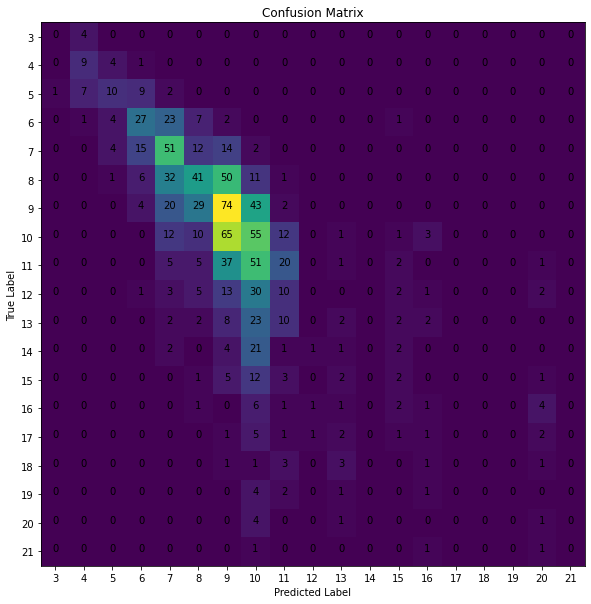

In [51]:
evaluate(model_NN_a, x_train_a, y_train_a, x_test_a, y_test_a)

#### SVM

In [52]:
# best params
param_grid_SVM = {'C': [.001, .005, .01, .05, .1],
                  'gamma': [1, 5, 10, 50, 100]}

In [53]:
classifer_SVM = SVC(kernel='rbf',random_state=100)
best_params_SVM_w = gridSearch(x_train_w, y_train_w, param_grid_SVM, classifer_SVM)
best_params_SVM_w

{'C': 0.1, 'gamma': 10}

In [54]:
classifer_SVM = SVC(kernel='rbf',random_state=100)
best_params_SVM_a = gridSearch(x_train_a, y_train_a, param_grid_SVM, classifer_SVM)
best_params_SVM_a

{'C': 0.1, 'gamma': 10}

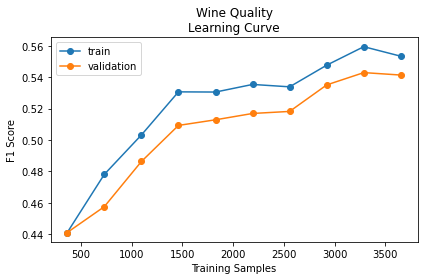

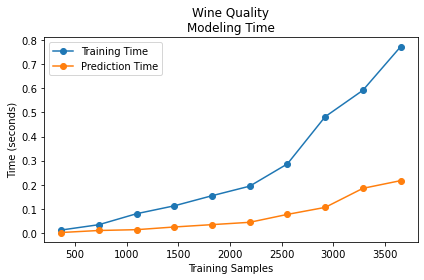

In [55]:
model_SVM_w = SVC(C=0.1, gamma=10, kernel='rbf', random_state=100)
curve_SVM_w = learning_curve_model_time(model_SVM_w, x_train_w, y_train_w, 5, "Wine Quality")

Train time: 0.8493001999886474
Prediction time: 0.2639076000050409
F1 Score: 0.26727178489991293
Accuracy: 0.534864643150123
Precision: 0.33295550705736254
Recall: 0.28218981018981015


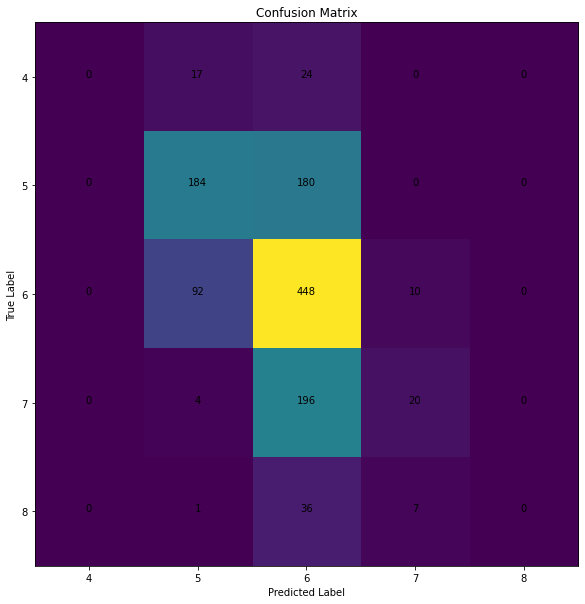

In [56]:
evaluate(model_SVM_w, x_train_w, y_train_w, x_test_w, y_test_w)

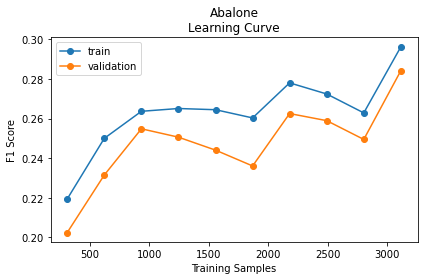

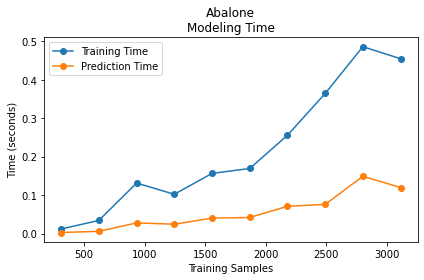

In [57]:
model_SVM_a = SVC(C=0.1, gamma=10, kernel='rbf', random_state=100)
curve_SVM_a = learning_curve_model_time(model_SVM_a, x_train_a, y_train_a, 5, "Abalone")

Train time: 0.7097806999954628
Prediction time: 0.23618940000596922
F1 Score: 0.11130979819126209
Accuracy: 0.25409047160731474
Precision: 0.11594902581596077
Recall: 0.12368745024880236


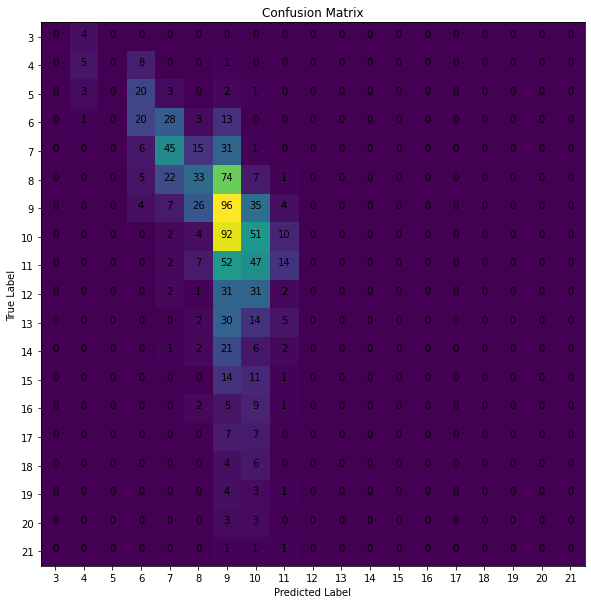

In [58]:
evaluate(model_SVM_a, x_train_a, y_train_a, x_test_a, y_test_a)

#### knn

In [59]:
# best params 1 and 47

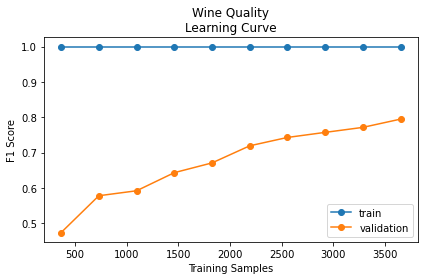

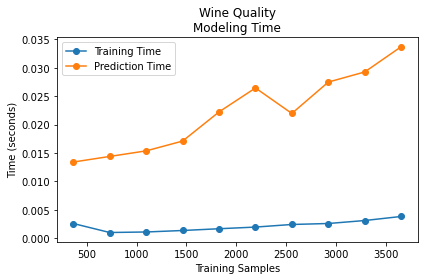

In [60]:
model_knn_w = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
curve_knn_w = learning_curve_model_time(model_knn_w, x_train_w, y_train_w, 5, "Wine Quality")

Train time: 0.007462699999450706
Prediction time: 0.04914819999248721
F1 Score: 0.5591157849854851
Accuracy: 0.6546349466776046
Precision: 0.5640110467373032
Recall: 0.5551608878925952


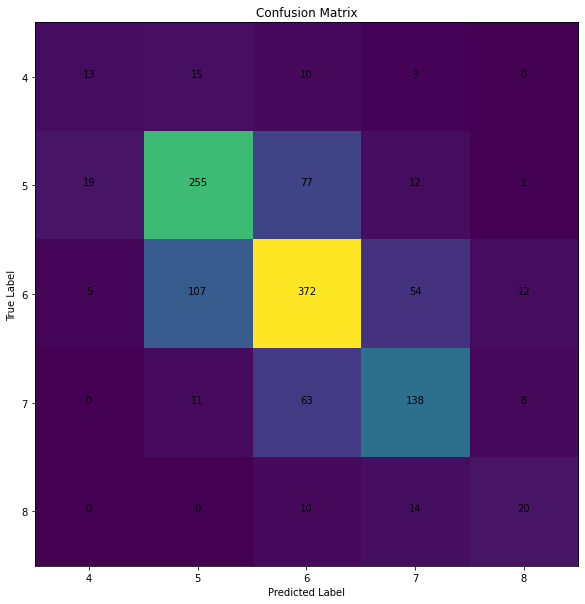

In [61]:
evaluate(model_knn_w, x_train_w, y_train_w, x_test_w, y_test_w)

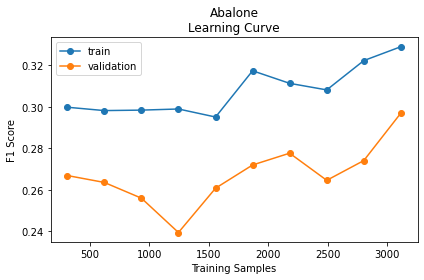

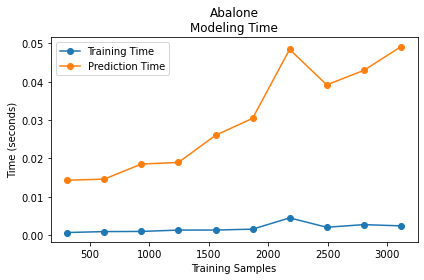

In [62]:
model_knn_a = KNeighborsClassifier(n_neighbors=47, n_jobs=-1)
curve_knn_a = learning_curve_model_time(model_knn_a, x_train_a, y_train_a, 5, "Abalone")

Train time: 0.004858000000240281
Prediction time: 0.05064220000349451
F1 Score: 0.15497568876363227
Accuracy: 0.29162656400384984
Precision: 0.1489282827448408
Recall: 0.16821230693636172


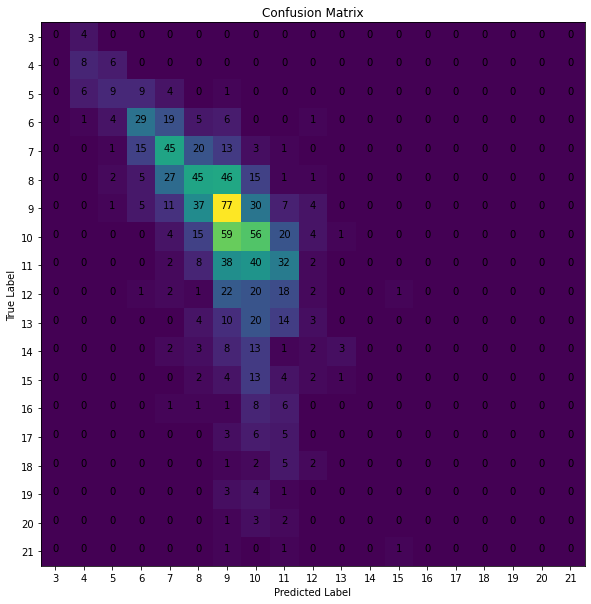

In [63]:
evaluate(model_knn_a, x_train_a, y_train_a, x_test_a, y_test_a)

#### trees

In [64]:
# best params
start_leaf_n = round(0.0075*len(x_train_w))
end_leaf_n = round(0.075*len(x_train_w)) 
param_grid_trees = {'min_samples_leaf': np.linspace(start_leaf_n, end_leaf_n, 20).astype('int'), 
              'max_depth': np.arange(1,20)}
classifier_trees = DecisionTreeClassifier()
best_params_trees_w = gridSearch(x_train_w, y_train_w, param_grid_trees, classifier_trees)
best_params_trees_w

{'max_depth': 5, 'min_samples_leaf': 53}

In [65]:
# best params
start_leaf_n = round(0.0075*len(x_train_a))
end_leaf_n = round(0.075*len(x_train_a)) 
param_grid_trees = {'min_samples_leaf': np.linspace(start_leaf_n, end_leaf_n, 20).astype('int'), 
              'max_depth': np.arange(1,20)}
classifier_trees = DecisionTreeClassifier()
best_params_trees_a = gridSearch(x_train_a, y_train_a, param_grid_trees, classifier_trees)
best_params_trees_a

{'max_depth': 4, 'min_samples_leaf': 45}

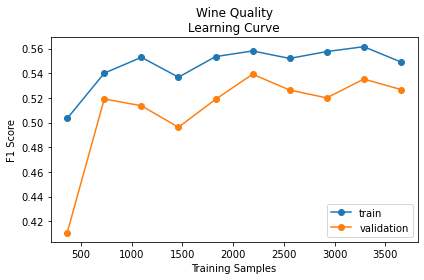

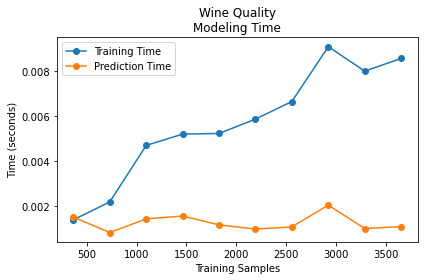

In [66]:
model_tree_w = DecisionTreeClassifier(max_depth=5, min_samples_leaf=53, 
                                         random_state=100, criterion='entropy')
curve_tree_w = learning_curve_model_time(model_tree_w, x_train_w, y_train_w, 5, "Wine Quality")

Train time: 0.014548999999533407
Prediction time: 0.000305800000205636
F1 Score: 0.2826387424835772
Accuracy: 0.5430680885972108
Precision: 0.3188718397379815
Recall: 0.2989590409590409


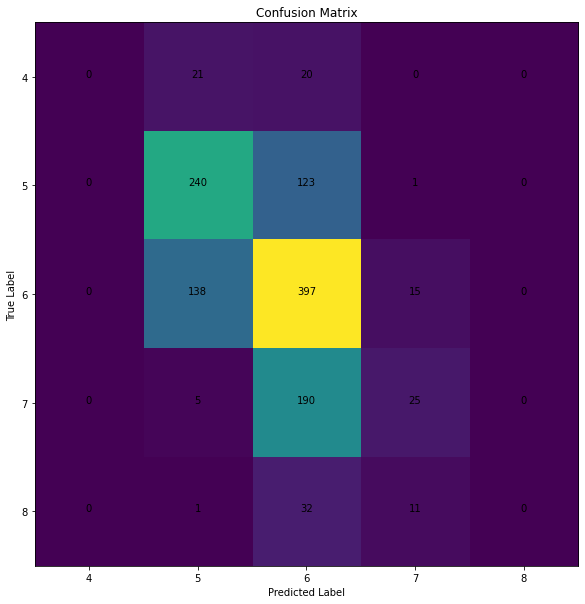

In [67]:
evaluate(model_tree_w, x_train_w, y_train_w, x_test_w, y_test_w)

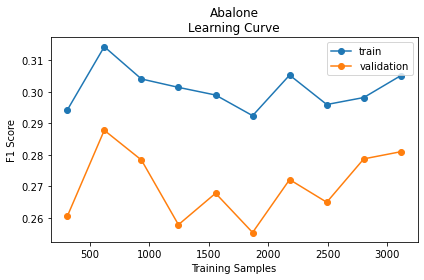

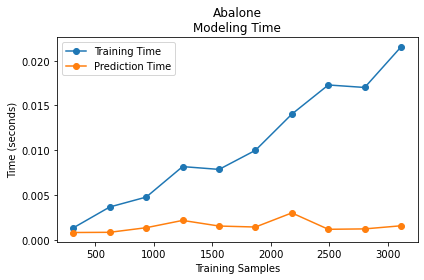

In [68]:
model_tree_a = DecisionTreeClassifier(max_depth=4, min_samples_leaf=45, 
                                         random_state=100, criterion='entropy')
curve_tree_a = learning_curve_model_time(model_tree_a, x_train_a, y_train_a, 5, "Abalone")

Train time: 0.022594800000661053
Prediction time: 0.0003589999978430569
F1 Score: 0.14821962423367194
Accuracy: 0.273339749759384
Precision: 0.14400440191273314
Recall: 0.17837530070979585


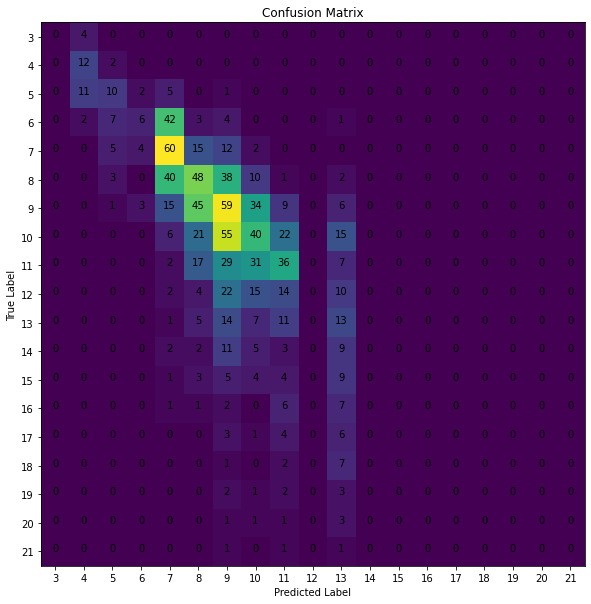

In [69]:
evaluate(model_tree_a, x_train_a, y_train_a, x_test_a, y_test_a)

#### boosting

In [72]:
# best params {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 27, 'n_estimators': 100}

start_leaf_n = round(0.0075*len(x_train_w))
end_leaf_n = round(0.075*len(x_train_w))
param_grid_boost = {'min_samples_leaf': np.linspace(start_leaf_n,end_leaf_n,3).astype('int'),
              'max_depth': np.arange(1,4),
              'n_estimators': np.linspace(10,100,3).astype('int'),
              'learning_rate': np.linspace(.001,.1,3)}
classifier_boost = GradientBoostingClassifier()
best_params_boost_w = gridSearch(x_train_w, y_train_w, param_grid_boost, classifier_boost)
best_params_boost_w

{'learning_rate': 0.1,
 'max_depth': 3,
 'min_samples_leaf': 27,
 'n_estimators': 100}

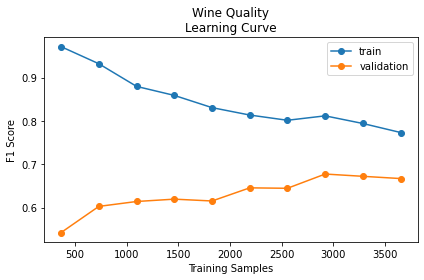

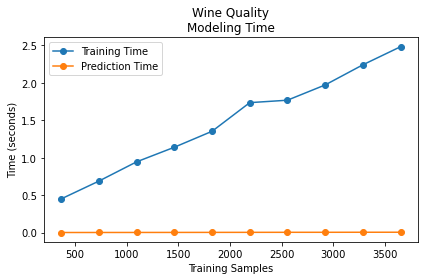

In [73]:
model_boost_w = GradientBoostingClassifier(max_depth=3, min_samples_leaf=27, 
                                              n_estimators=100, learning_rate=.1, random_state=100)
curve_boost_w = learning_curve_model_time(model_boost_w, x_train_w, y_train_w, 5, "Wine Quality")

Train time: 3.037252599999192
Prediction time: 0.010753399998066016
F1 Score: 0.4408693040038775
Accuracy: 0.6045939294503692
Precision: 0.5700666964598038
Recall: 0.4100455154601496


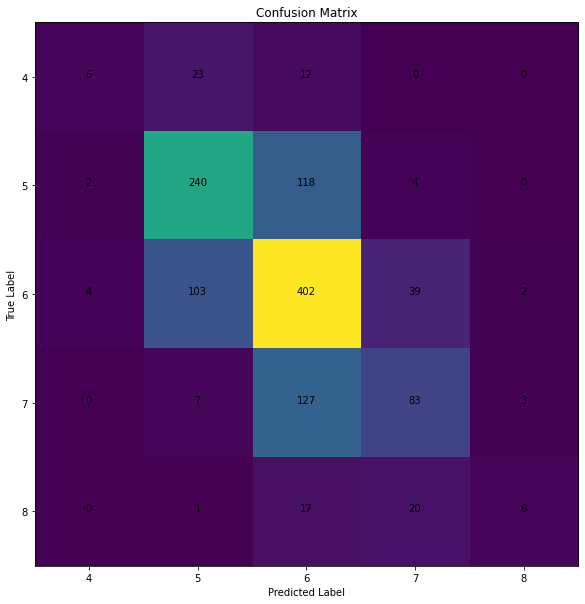

In [74]:
evaluate(model_boost_w, x_train_w, y_train_w, x_test_w, y_test_w)

In [75]:
# best params {'learning_rate': 0.1, 'max_depth': 2, 'min_samples_leaf': 234, 'n_estimators': 10}

start_leaf_n = round(0.0075*len(x_train_w))
end_leaf_n = round(0.075*len(x_train_w))
param_grid_boost = {'min_samples_leaf': np.linspace(start_leaf_n,end_leaf_n,3).astype('int'),
              'max_depth': np.arange(1,4),
              'n_estimators': np.linspace(10,100,3).astype('int'),
              'learning_rate': np.linspace(.001,.1,3)}
classifier_boost = GradientBoostingClassifier()
best_params_boost_a = gridSearch(x_train_a, y_train_a, param_grid_boost, classifier_boost)
best_params_boost_a

{'learning_rate': 0.1,
 'max_depth': 2,
 'min_samples_leaf': 27,
 'n_estimators': 10}

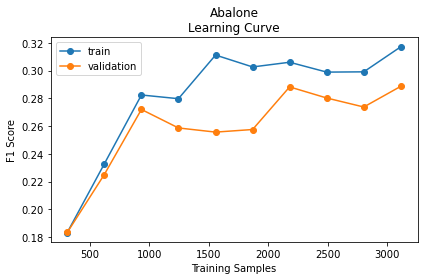

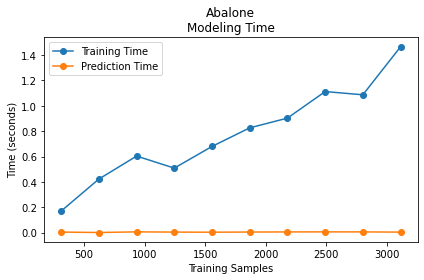

In [76]:
model_boost_a = GradientBoostingClassifier(max_depth=2, min_samples_leaf=234, 
                                              n_estimators=10, learning_rate=.1, random_state=100)
curve_boost_a = learning_curve_model_time(model_boost_a, x_train_a, y_train_a, 5, "Abalone")

Train time: 0.9736679999914486
Prediction time: 0.00387810000393074
F1 Score: 0.11549105519413323
Accuracy: 0.2646775745909528
Precision: 0.10128356881908139
Recall: 0.14623720977818602


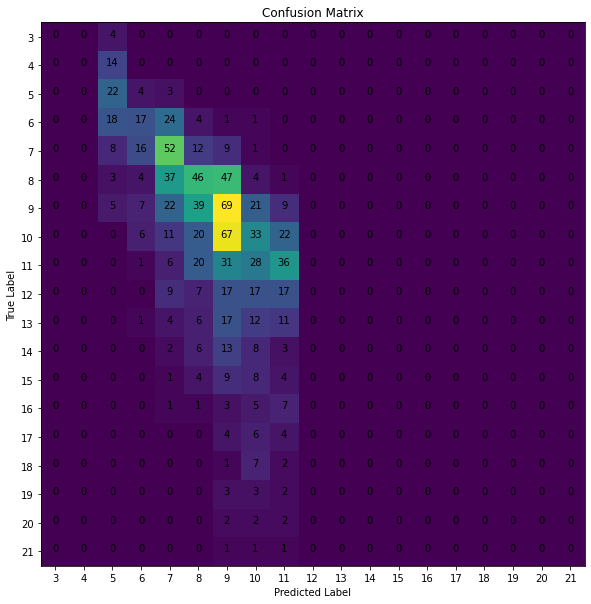

In [77]:
evaluate(model_boost_a, x_train_a, y_train_a, x_test_a, y_test_a)

In [554]:
#!pip freeze > requirements.txt